# EE511 Final Project

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

## Task 1: Train SqueezeNet

For task 1 we train SqueezeNet for 100 epochs and are able to get a final test accuracy of 69.66%.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Implementation

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

Note: MSR Initialization was added because the training would not work without it.

In [2]:
import math
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # # MSR initialization
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()
        # self.quant = QuantStub()
        # self.dequant = DeQuantStub()

        # self.upsample = nn.Upsample(size=224, mode='bilinear', align_corners=False)

        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(13)

    def forward(self, x):
        # x = self.upsample(x)
        # x = self.quant(x)
        x = self.maxpool1(self.conv1(x))

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        # x = self.dequant(x)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")
        # print(self)

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [3]:
def load_dataset(path='./data', batch_size=64):
  print("Loading the CIFAR10 dataset")

  transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), # scale RGB 0-255 to 0-1
    # normalize with known mean and std deviation of the CIFAR10 dataset
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
  ])

  # train_transform = transforms.Compose([
  #   transforms.RandomCrop(32, padding=4),
  #   transforms.RandomHorizontalFlip(),
  #   transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
  #   transforms.ToTensor(),
  #   transforms.Normalize((0.4914, 0.4822, 0.4465),
  #                   (0.2023, 0.1994, 0.2010)),
  # ])
  train_transform = transforms.Compose([
    transforms.Resize(224),  # Resize before any augmentation
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
  ])

  # get training data
  train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=train_transform)
  # get test data
  test_dataset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)
  # load the training data
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=8,pin_memory=True)
  # load the test data
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=8,pin_memory=True)

  print(f"Loaded train data: {len(train_loader.dataset)} total samples, {len(train_loader)} batches\n"
      f"Loaded test data: {len(test_loader.dataset)} total samples, {len(test_loader)} batches")

  return train_loader, test_loader

In [4]:
train_loader, test_loader = load_dataset(batch_size=128)

Loading the CIFAR10 dataset
Loaded train data: 50000 total samples, 391 batches
Loaded test data: 10000 total samples, 79 batches


## Train the model

In the cells below we define a function to visualize our training and train our model

In [5]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
  train_losses = metrics.get('train_loss',None)
  test_losses = metrics.get('test_loss',None)
  train_accs = metrics.get('train_acc',None)
  test_accs = metrics.get('test_acc',None)

  epochs = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 5))

  # Loss Graph
  plt.subplot(1, 2, 1)
  if train_losses:
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  if test_losses:
    plt.plot(epochs, test_losses, label='Test Loss', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Test Loss')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  # Accuracy Graph
  plt.subplot(1, 2, 2)
  if train_accs:
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
  if test_accs:
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training vs Test Accuracy')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

In [6]:
def train_model(model,train_loader,test_loader,train=True,test=True,device='cpu',epochs=10,lr=1e-3):
  model.to(device)
  metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

  # TRAINING LOOP
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
  criterion_test = nn.CrossEntropyLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
  # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


  for e in range(epochs):
    print(f"Epoch [{e+1}/{epochs}] ",end='')
    if train:
      model.train()
      train_loss, total_examples, correct = 0.0, 0, 0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True) # zero gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs,labels) # get loss from cost function
        loss.backward() # backward propagation
        optimizer.step() # update gradients

        # train_loss += loss.item() # track total loss up to this point
        train_loss += loss.item() * labels.size(0)
        _, pred_ind = outputs.max(1) # get index of prediction (highest value)
        total_examples += labels.size(0) # update count for this epoch with batch size
        correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      # scheduler.step() 
    #   train_loss /= len(train_loader) # get average per batch
      train_loss /= total_examples # get average per example
      train_acc = 100.0 * correct / total_examples

      metrics["train_loss"].append(train_loss)
      metrics["train_acc"].append(train_acc)

      print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% ",end='')

      # VALIDATION/TEST
    if test:
      model.eval()
      test_loss, total_examples, correct = 0.0, 0, 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs) # forward pass
          loss = criterion_test(outputs,labels) # get loss from cost function
          test_loss += loss.item() * labels.size(0) # update loss
          _, pred_ind = outputs.max(1) # get index of prediction (highest value)
          total_examples += labels.size(0) # update count for this epoch with batch size
          correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      test_loss /= total_examples
      test_acc = 100.0 * correct / total_examples

      metrics["test_loss"].append(test_loss)
      metrics["test_acc"].append(test_acc)

      print(f"Test/Val Loss: {test_loss:.4f}, Test/Val Acc: {test_acc:.2f}%")

  return metrics

In [ ]:
def init_weights_he(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(m.bias)
        
model_fp32 = SqueezeNetCIFAR10()
model_fp32.apply(init_weights_he)
# model_fp32.load_model('squeezenet_fp32.pth')

In [ ]:
# train, test = True, True
# epochs = 100
# fp32_metrics = train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

In [ ]:
# model_fp32.save_model("squeezenet_fp32.pth")

In [ ]:
# plot_metrics(fp32_metrics)

In [23]:
def evaluate(model, test_loader,device='cpu'):
  model.eval()
  model.to(device)
  correct, total = 0, 0

  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device, non_blocking=True)
          labels = labels.to(device, non_blocking=True)
          outputs = model(images)
          _, pred = outputs.max(1)
          correct += pred.eq(labels).sum().item()
          total += labels.size(0)

  acc = 100.0 * correct / total
  return acc

In [ ]:
# acc = evaluate(model_fp32,test_loader,device)
# print(f"FP32 Test Accuracy: {acc}%")

## Task 2: Quantize Squeezenet

For task 2 we use quantization aware training to quantize SqueezeNet to INT8. After training for 50 epochs we are able to achieve a final test accuracy of 69.16% with the quantized model.

In [ ]:
# import torch
# import torch.nn as nn
# from qtorch import FixedPoint, FloatingPoint
# from qtorch.quant import Quantizer

# # Define target fixed-point format (ap_fixed<8,4>)
# # 8 total bits, 4 fractional bits → Q3.4
# forward_num = FixedPoint(wl=8, fl=4, rounding="nearest", saturate=True)

# # Use standard FP32 for backward gradients
# backward_num = FloatingPoint(exp=8, man=23)  # 32-bit float

# # Create a quantizer
# Q = Quantizer(forward_number=forward_num,
#               backward_number=backward_num,
#               forward_rounding="nearest",
#               backward_rounding="stochastic")

# def add_weight_quant(module):
#     """
#     Recursively add weight quantization to Conv2d/Linear layers.
#     Stores original float weights as 'weight_fp'.
#     """
#     for name, child in module.named_children():
#         add_weight_quant(child)

#     if isinstance(module, (nn.Conv2d, nn.Linear)):
#         if not hasattr(module, 'weight_fp'):
#             module.weight_fp = nn.Parameter(module.weight.data.clone())
        
#         # Override forward to quantize weights
#         orig_forward = module.forward
#         def forward_hook(x, module=module, orig_forward=orig_forward):
#             module.weight.data = Q(module.weight_fp)
#             return orig_forward(x)
        
#         module.forward = forward_hook

# def apply_activation_q(model):
#     for name, child in model.named_children():
#         apply_activation_q(child)
#         if isinstance(child, nn.ReLU):
#             # replace inplace ReLU with non-inplace sequential
#             new_relu = nn.Sequential(nn.ReLU(inplace=False), Q)
#             setattr(model, name, new_relu)

# class SqueezeNetFixedQAT(nn.Module):
#     def __init__(self, base_model):
#         super().__init__()
#         self.model = base_model

#     def forward(self, x):
#         return self.model(x)


In [ ]:
# model_fp32 = SqueezeNetCIFAR10()
# model_fp32.load_model("squeezenet_fp32_final.pth")

# # Wrap for fixed-point QAT
# model_qat = SqueezeNetFixedQAT(model_fp32)

# # Apply activation quantization
# apply_activation_q(model_qat.model)

# # Apply weight quantization
# add_weight_quant(model_qat.model)

# # model_qat = SqueezeNetCIFAR10()
# # model_qat.model.load_model('squeezenet_fp32_final.pth')
# # add_weight_quant_hooks(model_qat)
# # apply_activation_q(model_qat)

In [18]:
import torch
import torch.nn as nn
import torch.quantization as tq

def prepare_model_for_qat(model_fp32):
    model = model_fp32.train()

    # Standard QAT config
    qat_config = tq.get_default_qat_qconfig("fbgemm")

    model_q = tq.prepare_qat(model, inplace=False)
    model_q.qconfig = qat_config

    return model_q

def convert_to_int8(model_qat):
    model_int8 = tq.convert(model_qat.eval(), inplace=False)
    return model_int8

def int8_to_apfixed84(weight_float):
    """
    Input: FP32 tensor
    Output: tensor quantized to ap_fixed<8,4>
    """

    scale = 16  # 2^4
    min_val = -8.0
    max_val = 7.9375

    # quantize
    q = torch.clamp(torch.round(weight_float * scale), min_val * scale, max_val * scale)
    return q / scale

def convert_model_to_apfixed84(model_int8):
    model_fixed = {}

    for name, module in model_int8.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            w = module.weight.data.float().cpu()
            w_fixed = int8_to_apfixed84(w)
            model_fixed[name] = w_fixed

            if module.bias is not None:
                b = module.bias.data.float().cpu()
                b_fixed = int8_to_apfixed84(b)
                model_fixed[name + ".bias"] = b_fixed

    return model_fixed

def load_fixed_weights_into_fp32(model_fp32, fixed_weights):
    for name, module in model_fp32.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            module.weight.data = fixed_weights[name]
            if module.bias is not None:
                module.bias.data = fixed_weights[name + ".bias"]
    return model_fp32



In [12]:
model_fp32 = SqueezeNetCIFAR10()
model_fp32.load_model("squeezenet_fp32_final.pth")

# Prepare QAT
model_qat = prepare_model_for_qat(model_fp32)

Model loaded from squeezenet_fp32_final.pth


C:\Users\K\AppData\Local\Temp\ipykernel_19016\40859219.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_q = tq.prepare_qat(model, inplace=False)


In [13]:
qat_metrics = train_model(model=model_qat,train_loader=train_loader,test_loader=test_loader,device=device,epochs=5)

Epoch [1/5] Train Loss: 1.0839, Train Acc: 77.09% Test/Val Loss: 0.5718, Test/Val Acc: 81.84%
Epoch [2/5] Train Loss: 1.0730, Train Acc: 77.61% Test/Val Loss: 0.6604, Test/Val Acc: 80.90%
Epoch [3/5] Train Loss: 1.0746, Train Acc: 77.59% Test/Val Loss: 0.5820, Test/Val Acc: 81.72%
Epoch [4/5] Train Loss: 1.0770, Train Acc: 77.22% Test/Val Loss: 0.6129, Test/Val Acc: 81.71%
Epoch [5/5] Train Loss: 1.0759, Train Acc: 77.55% Test/Val Loss: 0.6086, Test/Val Acc: 81.17%


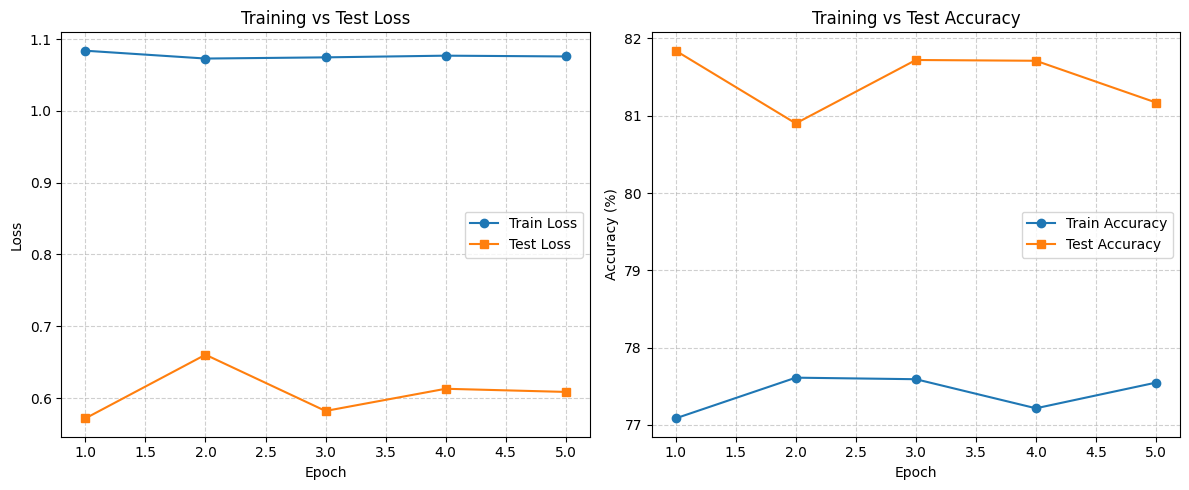

In [14]:
plot_metrics(qat_metrics)

In [15]:
# model_int8 = tq.convert(model_qat.eval(), inplace=False)
model_int8 = convert_to_int8(model_qat)

C:\Users\K\AppData\Local\Temp\ipykernel_19016\40859219.py:17: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = tq.convert(model_qat.eval(), inplace=False)


In [16]:
model_int8.eval()
acc = evaluate(model_int8,test_loader)
print(f"QAT Test Accuracy: {acc}%")

QAT Test Accuracy: 81.17%


In [ ]:
model_qat.eval()
torch.save(model_qat.state_dict(), "squeezenet_quantized.pth")

In [19]:
model_fixed_dict = convert_model_to_apfixed84(model_int8)

In [20]:
torch.save(model_fixed_dict, "squeezenet_apfixed84.pth")

# Optional: if you want to save the model object (with architecture)
# torch.save(model_fixed_eval, "squeezenet_apfixed84_fullmodel.pth")

In [25]:
# Load fixed weights into evaluation model
model_fixed_eval = load_fixed_weights_into_fp32(SqueezeNetCIFAR10(), model_fixed_dict)
model_fixed_eval.eval()

# Evaluate ap_fixed<8,4>
acc_fixed = evaluate(model_fixed_eval, test_loader,device)
print(f"Fixed Point Test Accuracy: {acc}%")

Fixed Point Test Accuracy: 81.17%
